In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

# in this file, we implement a UNet, and train on the "previous work" OCT

# functions to display images


In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28)):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()
    


contracting block

In [3]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        self.conv1= nn.Conv2d(input_channels, 2*input_channels, kernel_size=(3,3))
        self.conv2= nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=(3,3))
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

    

In [4]:
#UNIT TEST
def test_contracting_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    # Make sure that the first convolution has the right shape
    assert tuple(test_out_conv1.shape) == (test_samples, test_channels * 2, test_size - 2, test_size - 2)
    # Make sure that the right activation is used
    assert torch.all(test_block.activation(test_out_conv1) >= 0)
    assert torch.max(test_block.activation(test_out_conv1)) >= 1
    test_out_conv2 = test_block.conv2(test_out_conv1)
    # Make sure that the second convolution has the right shape
    assert tuple(test_out_conv2.shape) == (test_samples, test_channels * 2, test_size - 4, test_size - 4)
    test_out = test_block(test_in)
    # Make sure that the pooling has the right shape
    assert tuple(test_out.shape) == (test_samples, test_channels * 2, test_size // 2 - 2, test_size // 2 - 2)

test_contracting_block()
test_contracting_block(10, 9, 8)
print("Success!")

Success!


# expanding block

In [5]:
def crop(image, new_shape):
    batchSize, channels, height, width = image.shape
    newBatchSize, newChannels, newH, newW = new_shape
    # this is a center crop style
    offsetBatch = (batchSize - newBatchSize)//2
    offsetChannels = (channels - newChannels)//2
    offsetY = (height - newH)//2
    offsetX = (width - newW)//2

    cropped_image = image[offsetBatch:offsetBatch+newBatchSize, 
        offsetChannels:offsetChannels+newChannels, 
        offsetY:offsetY+newH, offsetX:offsetX+newW]
    return cropped_image

In [6]:
#UNIT TEST
def test_expanding_block_crop(test_samples=100, test_channels=10, test_size=100):
    # Make sure that the crop function is the right shape
    skip_con_x = torch.randn(test_samples, test_channels, test_size + 6, test_size + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    cropped = crop(skip_con_x, x.shape)
    assert tuple(cropped.shape) == (test_samples, test_channels, test_size, test_size)

    # Make sure that the crop function takes the right area
    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, test_size // 2, test_size // 2]))
    assert cropped.max() == (test_size - 1) * 2 - test_size // 2
    assert cropped.min() == test_size // 2
    assert cropped.mean() == test_size - 1

    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    crop_size = 5
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, crop_size, crop_size]))
    assert cropped.max() <= (test_size + crop_size - 1) and cropped.max() >= test_size - 1
    assert cropped.min() >= (test_size - crop_size - 1) and cropped.min() <= test_size - 1
    assert abs(cropped.mean() - test_size) <= 2

test_expanding_block_crop()
print("Success!")

Success!


the expanding block

In [7]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels):
        super(ExpandingBlock,self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        output_channels = input_channels//2
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=(2,2))
        self.conv2 = nn.Conv2d(input_channels, output_channels, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(output_channels, output_channels, kernel_size=(3,3))

        self.activation = nn.ReLU()

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x,skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x
        


In [8]:
#UNIT TEST
def test_expanding_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
    orginal_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, orginal_x], axis=1)
    x = test_block.conv2(x)
    # Make sure that the second convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
    x = test_block.conv3(x)
    # Make sure that the final convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
    x = test_block.activation(x)

test_expanding_block()
print("Success!")

Success!


#final layer

In [9]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()

        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=(1,1))

    def forward(self, x):
        x = self.conv(x)
        return x

In [10]:
# UNIT TEST
assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
print("Success!")

Success!


# UNET

In [11]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)

        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)

        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self,x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)

        x5 = self.expand1(x4,x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        return xn

In [12]:
#UNIT TEST
test_unet = UNet(1, 3)
assert tuple(test_unet(torch.randn(1, 1, 256, 256)).shape) == (1, 3, 117, 117)
print("Success!")

Success!


# training

In [13]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
input_dim = 1
output_dim = 1
display_step = 20
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 373
# device = 'cpu'
device='cuda'

In [14]:
from skimage import io
import numpy as np
train_images_path = r"C:\Users\DenisTran\Documents\CNN resources\UNet tutorial\tifs\sections-180-220.tif"
train_label_path = r"C:\Users\DenisTran\Documents\CNN resources\UNet tutorial\tifs\mithocondria.tif"
volumes = torch.Tensor(io.imread(train_images_path))[:, None, :, :] / 255
labels = torch.Tensor(io.imread(train_label_path, plugin="tifffile").astype(np.int16))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

C:\Users\DenisTran\AppData\Roaming\Python\Python37\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [15]:
print(volumes.shape, labels.shape)

torch.Size([30, 1, 512, 512]) torch.Size([30, 1, 373, 373])


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.7237062454223633


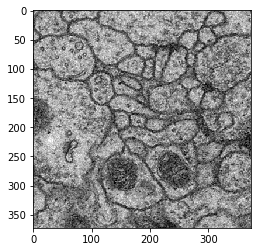

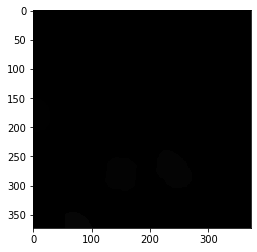

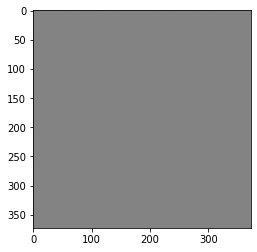

Epoch 0: Step 20: U-Net loss: 0.055155832320451736


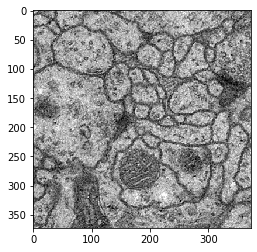

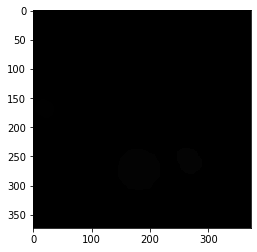

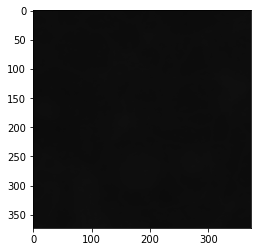

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Step 40: U-Net loss: 0.01353627908974886


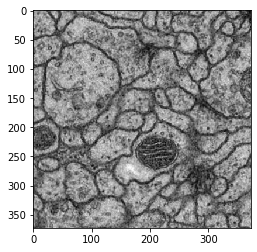

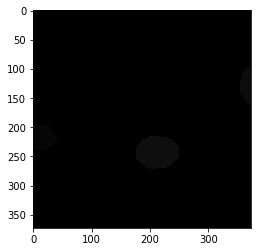

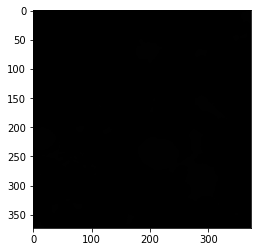

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Step 60: U-Net loss: 0.004417247138917446


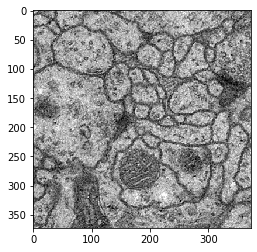

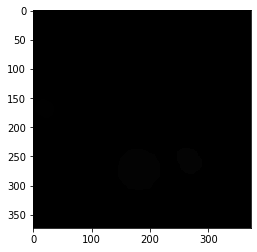

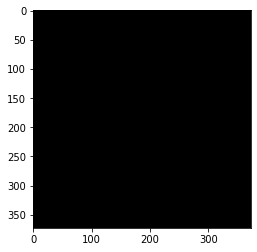

Epoch 2: Step 80: U-Net loss: 0.005226681008934975


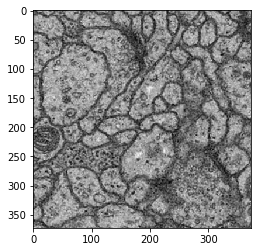

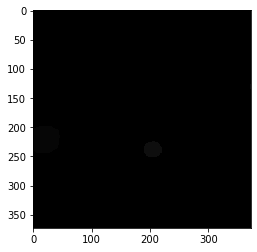

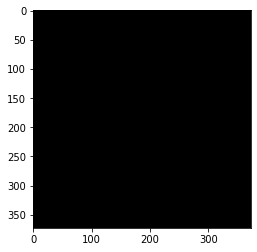

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size= batch_size,
        shuffle=True
    )
    unet = UNet(input_dim, output_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0

    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # flatten
            real = real.to(device)
            labels = labels.to(device)

            # update UNet
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(
                    crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    size=(input_dim, target_shape, target_shape)
                )
                show_tensor_images(labels, size=(output_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(output_dim, target_shape, target_shape))
            cur_step += 1
train()

In [19]:
import torch
devices = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(devices)

In [22]:
import torch
print(torch.__version__)

1.6.0+cu101


In [27]:
devices = [d for d in range(torch.cuda.device_count())]
device_names  = [torch.cuda.get_device_name(d) for d in devices]
print(device_names)

['Quadro T2000']


['Quadro T2000']
